# Descreptive analysis of stratification approach

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import make_friedman1
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import json
from sklearn.dummy import DummyRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
from utils import FriedmanDataset, create_cont_folds, fold_visualizer, perform_ks_test
from scipy.stats import expon
from scipy.stats import gaussian_kde
from scipy.stats import ks_2samp


In [57]:
# Data Creation
n_train= 1000
n_test= 100000
n_features = 10
FD_noise= 0
transformation='sqrt'
seed=567

# Stratification
n_groups = 200

# RandomSearchCV
n_folds = 4
n_iter= 200
n_repetitions= 10
scoring= 'neg_mean_squared_error' 
n_jobs= -1



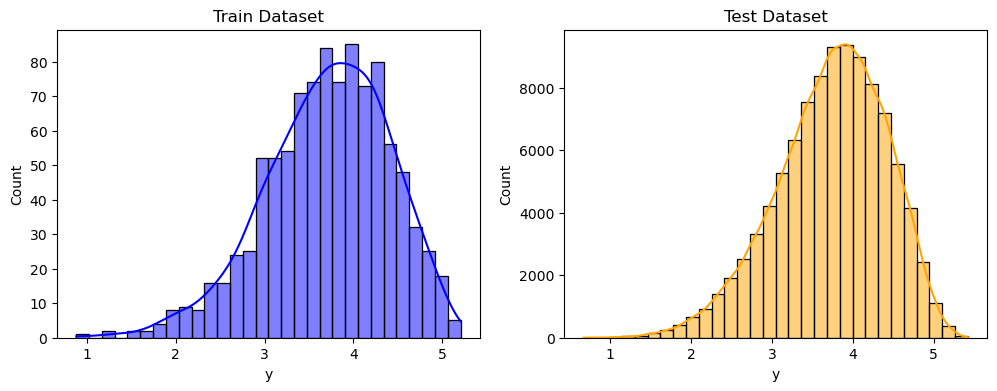

In [58]:
train = FriedmanDataset(n_samples=n_train, 
                            n_features=n_features, 
                            noise=FD_noise, 
                            random_state=seed)
train.transform(transformation=transformation)


test = FriedmanDataset(n_samples=n_test,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=seed)
test.transform(transformation=transformation)


# Show here histograms of train and train datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train.df, x='y', bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Train Dataset')

sns.histplot(test.df, x='y', bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Test Dataset')

plt.show()

## Kolmogorov-Smirnov test (exemplary)
1. Test if train and test split come from same distribution.   
2. Test if train and exponentail data come form same distribution.

In [59]:


def perform_ks_test(data1, data2):
    
    # Perform the Kolmogorov-Smirnov test
    statistic, p_value = ks_2samp(data1, data2)

    # Print the results
    print("K-S Statistic:", statistic)
    print("P-value:", p_value)

    # Interpret the results
    alpha = 0.05
    if p_value > alpha:
        print("Same Distributions: Fail to reject the null hypothesis. Data1 and Data2 may come from the same distribution.")
    else:
        print("Different Distributions: Reject the null hypothesis. Data1 and Data2 likely come from different distributions.")

    return statistic, p_value


In [60]:
# 1. Perform the Kolmogorov-Smirnov test: Test if train and test split come from same distribution.   
perform_ks_test(train.df['y'], test.df['y'])

K-S Statistic: 0.025859999999999994
P-value: 0.5137146665586914
Same Distributions: Fail to reject the null hypothesis. Data1 and Data2 may come from the same distribution.


(0.025859999999999994, 0.5137146665586914)

In [61]:
# 2. Perform the Kolmogorov-Smirnov test: Test if train and test split come from same distribution.   
# ceate data follwing exponential distribution
y_expon = expon.rvs(size=n_train, random_state=seed)
perform_ks_test(train.df['y'], y_expon)

K-S Statistic: 0.859
P-value: 0.0
Different Distributions: Reject the null hypothesis. Data1 and Data2 likely come from different distributions.


(0.859, 0.0)

## Calculate Kernel Density Estimation 

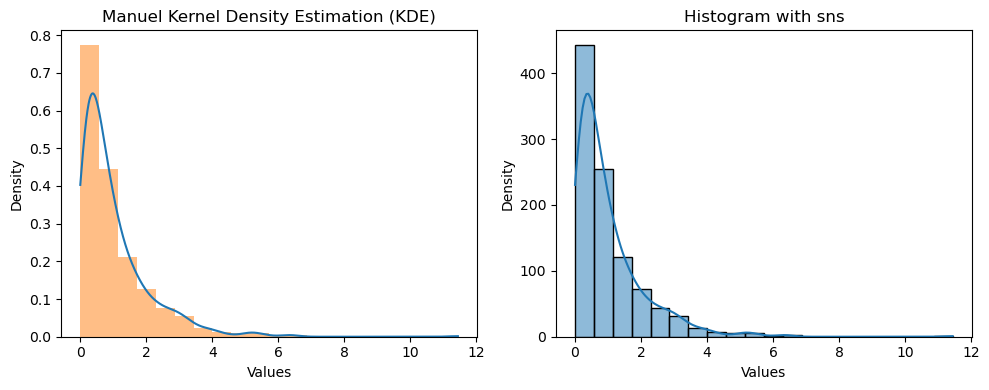

In [62]:
# Calculate KDE
kde = gaussian_kde(y_expon)

# Create a range of values for the x-axis
y_expon_kde = np.linspace(min(y_expon), max(y_expon), 1000)

# Create a 2x1 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the KDE in the first subplot
axs[0].plot(y_expon_kde, kde(y_expon_kde), label='KDE')
axs[0].hist(y_expon, density=True, alpha=0.5, bins=20, label='Histogram') 
axs[0].set_title('Manuel Kernel Density Estimation (KDE)')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Density')

# Plot the histogram in the second subplot
sns.histplot(y_expon, bins=20, kde=True, ax=axs[1])
axs[1].set_title('Histogram with sns')
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Density')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [73]:
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np


def plot_intersection(data1, data2):
    data_dict = {'data1': data1, 'data2': data2}
    min_data = min(min(data.values) for data in data_dict.values())
    max_data = max(max(data.values) for data in data_dict.values())
    min_len = min([len(data) for data in data_dict.values()])
    print(min_len)
    x = np.linspace(min_data, max_data, min_len)
    ys = []
    for label, data in data_dict.items():
        kde_func = gaussian_kde(data)
        y = kde_func(x)
        plt.plot(x, y, label=label, color='#004d1a' if label == 'data1' else '#00b33c')
        ys.append(y)
    y_intersection = np.amin(ys, axis=0)
    area = np.trapz(y_intersection, x)
    fill_poly = plt.fill_between(x, 0, y_intersection, fc='#b3fff0', alpha=0.2,
                                 label=f'intersection: {area:.3f} ')
    fill_poly.set_hatch('xxx')
    #plt.legend()
    plt.show()

    return area



## Cross-validation (random)

In [64]:
def fold_visualizer(data, fold_idxs, seed_num, stratified= False):
    '''
    Function to visualize the folds.
    Inputs:
        data: the target variable
        fold_idxs: the number of folds
        seed_num: the seed numbers as a list
    Outputs:
        None (it plots the folds)
    '''
    # for plotting title
    if stratified:
        stratified_title = "Stratified Split"
    else:
        stratified_title = "Random Split"

    fig, axs = plt.subplots(len(fold_idxs)//2, 2, figsize=(10,(len(fold_idxs)//2)*2))
    fig.suptitle(stratified_title + " with seed: " + str(seed_num), fontsize=10)
    for fold_id, (train_ids, val_ids) in enumerate(fold_idxs):
        sns.histplot(data=data[train_ids],
                     kde=True,
                     stat="density",
                     alpha=0.15,
                     label="Train Set",
                     bins=30,
                     line_kws={"linewidth":1},
                     ax=axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)])
        sns.histplot(data=data[val_ids],
                     kde=True,
                     stat="density", 
                     color="darkorange",
                     alpha=0.15,
                     label="Validation Set",
                     bins=30,
                     line_kws={"linewidth":1},
                     ax=axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)])
        axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)].legend()
        axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)].set_title("Split " + str(fold_id+1))
    plt.show()

    for fold_id, (train_ids, val_ids) in enumerate(fold_idxs):
        print("Split " + str(fold_id+1))
        print(len(data[train_ids]))
        print(len(data[val_ids]))
        perform_ks_test(data[train_ids], data[val_ids])
        plot_intersection(data[train_ids], data[val_ids])

In [65]:
def fold_visualizer(data, fold_idxs, seed_num, stratified=False):
    '''
    Function to visualize the folds.
    Inputs:
        data: the target variable
        fold_idxs: the number of folds
        seed_num: the seed numbers as a list
    Outputs:
        results: a dictionary containing the outputs of perform_ks_test() and plot_intersection()
    '''
    ks_statistic_list = []
    p_value_list = []
    intersection_area_list = []
   

    # for plotting title
    if stratified:
        stratified_title = "Stratified Split"
    else:
        stratified_title = "Random Split"

    fig, axs = plt.subplots(len(fold_idxs)//2, 2, figsize=(10,(len(fold_idxs)//2)*2))
    fig.suptitle(stratified_title + " with seed: " + str(seed_num), fontsize=10)
    for fold_id, (train_ids, val_ids) in enumerate(fold_idxs):
        sns.histplot(data=data[train_ids],
                     kde=True,
                     stat="density",
                     alpha=0.15,
                     label="Train Set",
                     bins=30,
                     line_kws={"linewidth":1},
                     ax=axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)])
        sns.histplot(data=data[val_ids],
                     kde=True,
                     stat="density", 
                     color="darkorange",
                     alpha=0.15,
                     label="Validation Set",
                     bins=30,
                     line_kws={"linewidth":1},
                     ax=axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)])
        axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)].legend()
        axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)].set_title("Split " + str(fold_id+1))
    plt.show()

    for fold_id, (train_ids, val_ids) in enumerate(fold_idxs):
        print("Split " + str(fold_id+1))
        #print(len(data[train_ids]))
        #print(len(data[val_ids]))

        # Perform the Kolmogorov-Smirnov test and store the results in the dictionary
        ks_statistic, p_value = perform_ks_test(data[train_ids], data[val_ids])
        print("K-S Statistic:", ks_statistic)
        print("P-value:", p_value)

        # Calculate the intersection and store the result in the dictionary
        intersection_area = plot_intersection(data[train_ids], data[val_ids])
        print("Intersection Area:", intersection_area)
        ks_statistic_list.append(ks_statistic)
        p_value_list.append(p_value)
        intersection_area_list.append(intersection_area)
    results = {'ks_statistic': ks_statistic_list, 'p_value': p_value_list, 'intersection_area': intersection_area_list}
    return results


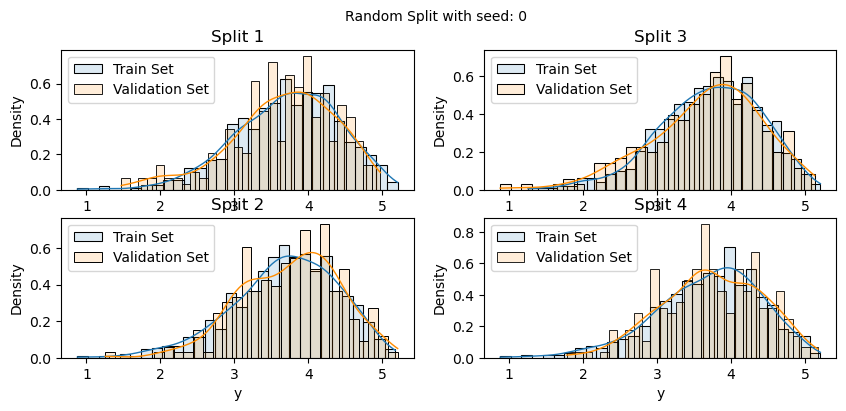

Split 1
K-S Statistic: 0.058666666666666666
P-value: 0.5294757647328986
Same Distributions: Fail to reject the null hypothesis. Data1 and Data2 may come from the same distribution.
K-S Statistic: 0.058666666666666666
P-value: 0.5294757647328986
250


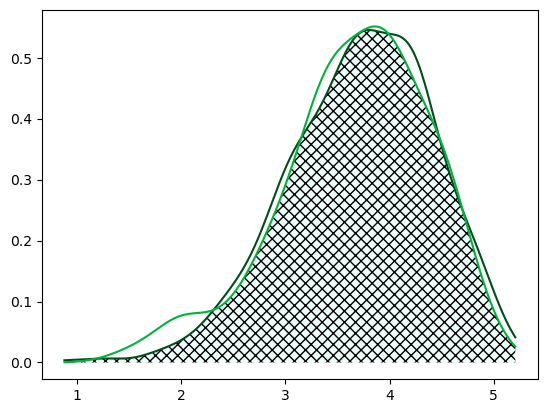

Intersection Area: 0.9540236421434987
Split 2
K-S Statistic: 0.058666666666666666
P-value: 0.5294757647328986
Same Distributions: Fail to reject the null hypothesis. Data1 and Data2 may come from the same distribution.
K-S Statistic: 0.058666666666666666
P-value: 0.5294757647328986
250


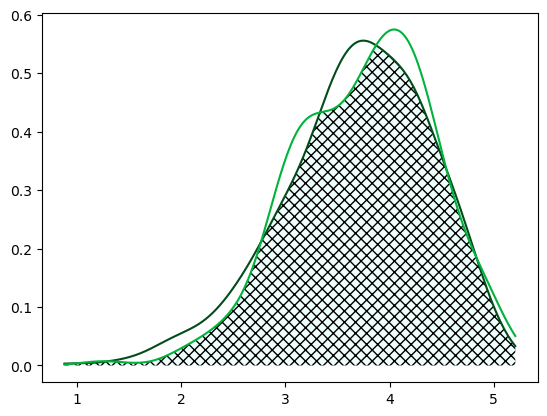

Intersection Area: 0.9350305758542055
Split 3
K-S Statistic: 0.052
P-value: 0.6815934044551095
Same Distributions: Fail to reject the null hypothesis. Data1 and Data2 may come from the same distribution.
K-S Statistic: 0.052
P-value: 0.6815934044551095
250


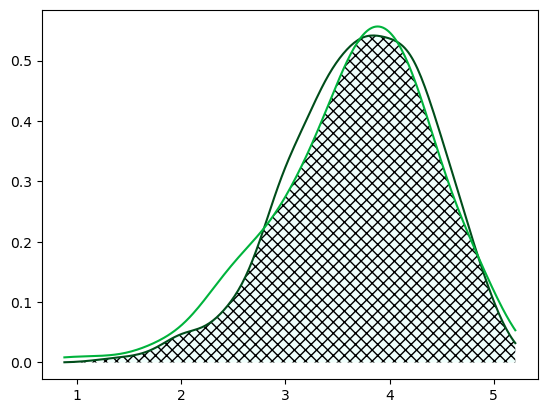

Intersection Area: 0.9390970910722181
Split 4
K-S Statistic: 0.05466666666666667
P-value: 0.6200208789083654
Same Distributions: Fail to reject the null hypothesis. Data1 and Data2 may come from the same distribution.
K-S Statistic: 0.05466666666666667
P-value: 0.6200208789083654
250


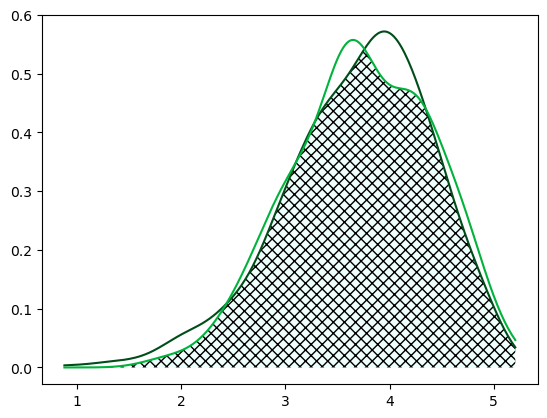

Intersection Area: 0.9431524154926233


In [74]:
for i in range(1):
    cv_splits_random = list(KFold(n_folds, shuffle=True, random_state=i).split(train.df['y']))
    results_random_split = fold_visualizer(data=train.df['y'], fold_idxs=cv_splits_random, seed_num=i)

## Cross-validation (stratified)

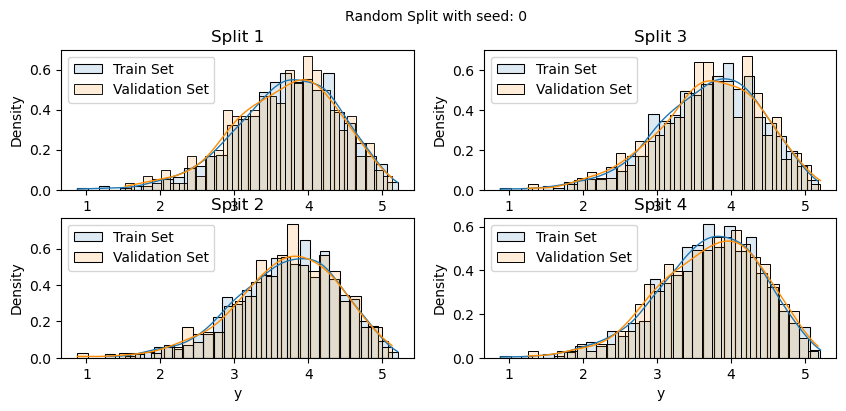

Split 1
K-S Statistic: 0.030666666666666665
P-value: 0.9935704028208215
Same Distributions: Fail to reject the null hypothesis. Data1 and Data2 may come from the same distribution.
K-S Statistic: 0.030666666666666665
P-value: 0.9935704028208215
250


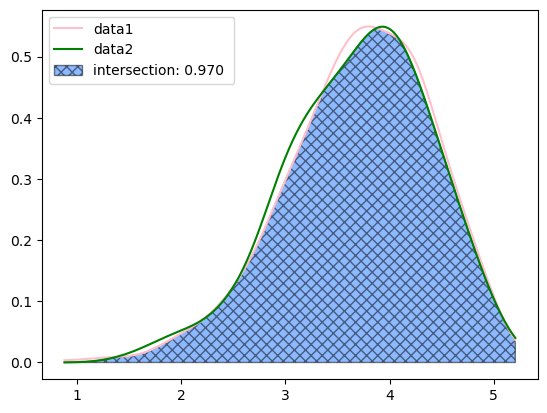

Intersection Area: 0.969733421187281
Split 2
K-S Statistic: 0.028
P-value: 0.9981654157284734
Same Distributions: Fail to reject the null hypothesis. Data1 and Data2 may come from the same distribution.
K-S Statistic: 0.028
P-value: 0.9981654157284734
250


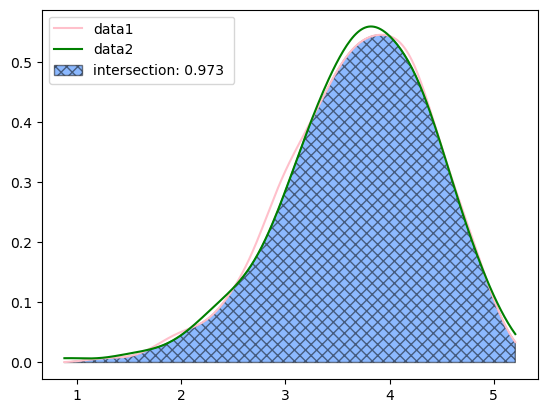

Intersection Area: 0.9728943712688733
Split 3
K-S Statistic: 0.025333333333333333
P-value: 0.9996601643052309
Same Distributions: Fail to reject the null hypothesis. Data1 and Data2 may come from the same distribution.
K-S Statistic: 0.025333333333333333
P-value: 0.9996601643052309
250


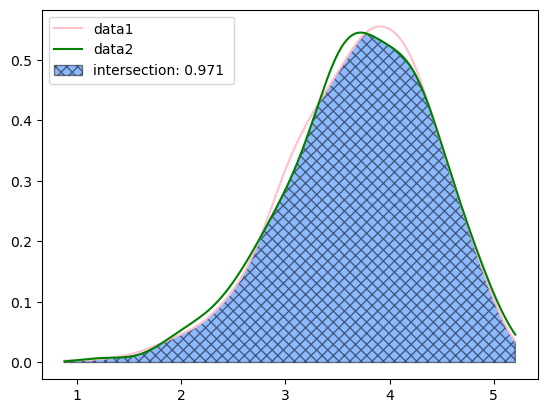

Intersection Area: 0.9706715502270242
Split 4
K-S Statistic: 0.025333333333333333
P-value: 0.9996601643052309
Same Distributions: Fail to reject the null hypothesis. Data1 and Data2 may come from the same distribution.
K-S Statistic: 0.025333333333333333
P-value: 0.9996601643052309
250


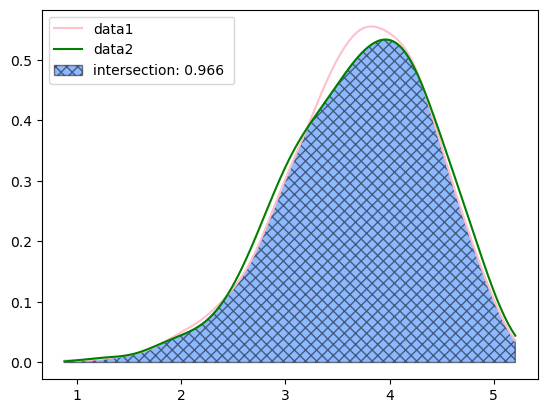

Intersection Area: 0.9662550410528085


In [68]:
for i in range(1):
    cv_splits_stratified = create_cont_folds(y=train.df['y'], n_folds=n_folds, n_groups=n_groups, seed=i)
    results_stratified = fold_visualizer(data=train.df['y'], fold_idxs=cv_splits_stratified, seed_num=i)

Comparison:

In [ ]:

mean_results = {}

for key, values in results_random_split.items():
    mean_results[key] = np.mean(values)

print(mean_results)

{'ks_statistic': 0.056, 'p_value': 0.590141453207318, 'intersection_area': 0.9428259311406364}


In [ ]:
# calculate the mean and std of the results
print("Mean KS Statistic:", np.mean(results_random_split['ks_statistic']))
print("Std KS Statistic:", np.std(results_random_split['ks_statistic']))
print("Mean P-value:", np.mean(results_random_split['p_value']))
print("Std P-value:", np.std(results_random_split['p_value']))
print("Mean Intersection Area:", np.mean(results_random_split['intersection_area']))
print("Std Intersection Area:", np.std(results_random_split['intersection_area']))

Mean KS Statistic: 0.056
Std KS Statistic: 0.0028284271247461905
Mean P-value: 0.590141453207318
Std P-value: 0.06445326016464074
Mean Intersection Area: 0.9428259311406364
Std Intersection Area: 0.0070740217704153945


In [ ]:
results_stratified
# calculate the mean and std of the results
print("Mean KS Statistic:", np.mean(results_stratified['ks_statistic']))
print("Std KS Statistic:", np.std(results_stratified['ks_statistic']))
print("Mean P-value:", np.mean(results_stratified['p_value']))
print("Std P-value:", np.std(results_stratified['p_value']))
print("Mean Intersection Area:", np.mean(results_stratified['intersection_area']))
print("Std Intersection Area:", np.std(results_stratified['intersection_area']))

Mean KS Statistic: 0.02733333333333333
Std KS Statistic: 0.002211083193570266
Mean P-value: 0.9977640367899391
Std P-value: 0.00249691159373578
Mean Intersection Area: 0.9698885959339968
Std Intersection Area: 0.002391364833382195
